Pipeline
    
    1) Removing HTML tagas and URLs, Punctiation*, Replacing emoticons*.
    2) Tokenization
    3) Removing Stop Words
    4) Splitting data: Training, Validation, Test
    5) TF-IDF Calculation

    About the labels
        # 0 negative
        # 1 neutral
        # 2 positive

# A) Defining working environment.

In [1]:
# Support Vector Machine working environment.
# Getting ready the work environment. Importing libraries and modules: 

import time
import pandas as pd
import re
import nltk
import torch 
import torch.nn as nn
import numpy as np
import string
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from collections import Counter
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

#===========         Extra tools for the statistic analysis              ======================
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
#----------------------------------------------------------------------

stop_words = stopwords.words('english')
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
vectorizer = CountVectorizer()

# B) Load and check dataset

In [2]:
# Importing dataset from the hugging face
from datasets import load_dataset

dataset1 = load_dataset('financial_phrasebank', 'sentences_50agree')
dataset2 = load_dataset('financial_phrasebank', 'sentences_66agree')
dataset3 = load_dataset('financial_phrasebank', 'sentences_75agree')

Found cached dataset financial_phrasebank (C:/Users/nonox/.cache/huggingface/datasets/financial_phrasebank/sentences_50agree/1.0.0/550bde12e6c30e2674da973a55f57edde5181d53f5a5a34c1531c53f93b7e141)


  0%|          | 0/1 [00:00<?, ?it/s]

Found cached dataset financial_phrasebank (C:/Users/nonox/.cache/huggingface/datasets/financial_phrasebank/sentences_66agree/1.0.0/550bde12e6c30e2674da973a55f57edde5181d53f5a5a34c1531c53f93b7e141)


  0%|          | 0/1 [00:00<?, ?it/s]

Found cached dataset financial_phrasebank (C:/Users/nonox/.cache/huggingface/datasets/financial_phrasebank/sentences_75agree/1.0.0/550bde12e6c30e2674da973a55f57edde5181d53f5a5a34c1531c53f93b7e141)


  0%|          | 0/1 [00:00<?, ?it/s]

In [3]:
# Checking dataset
print(dataset1)

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 4846
    })
})


In [4]:
# Transforming the data set into a more friendly frame (tables)
df50 = pd.DataFrame(dataset1['train'])
df66 = pd.DataFrame(dataset2['train'])
df75 = pd.DataFrame(dataset3['train'])

In [5]:
# Checking data
print(df50)
print("\n")
print(df66)
print("\n")
print(df75)

                                               sentence  label
0     According to Gran , the company has no plans t...      1
1     Technopolis plans to develop in stages an area...      1
2     The international electronic industry company ...      0
3     With the new production plant the company woul...      2
4     According to the company 's updated strategy f...      2
...                                                 ...    ...
4841  LONDON MarketWatch -- Share prices ended lower...      0
4842  Rinkuskiai 's beer sales fell by 6.5 per cent ...      1
4843  Operating profit fell to EUR 35.4 mn from EUR ...      0
4844  Net sales of the Paper segment decreased to EU...      0
4845  Sales in Finland decreased by 10.5 % in Januar...      0

[4846 rows x 2 columns]


                                               sentence  label
0     According to Gran , the company has no plans t...      1
1     Technopolis plans to develop in stages an area...      1
2     With the new productio

In [6]:
# Checking the data we will preproccess
print(df50['sentence'])

0       According to Gran , the company has no plans t...
1       Technopolis plans to develop in stages an area...
2       The international electronic industry company ...
3       With the new production plant the company woul...
4       According to the company 's updated strategy f...
                              ...                        
4841    LONDON MarketWatch -- Share prices ended lower...
4842    Rinkuskiai 's beer sales fell by 6.5 per cent ...
4843    Operating profit fell to EUR 35.4 mn from EUR ...
4844    Net sales of the Paper segment decreased to EU...
4845    Sales in Finland decreased by 10.5 % in Januar...
Name: sentence, Length: 4846, dtype: object


In [7]:
# Checking data balance
sentiment_counts = df50['label'].value_counts()
print('Sentiment distribution: 2-Positive, 1-Neutral, 0-Negative, ')
print(sentiment_counts)

Sentiment distribution: 2-Positive, 1-Neutral, 0-Negative, 
1    2879
2    1363
0     604
Name: label, dtype: int64


# C) Text preprocessing

## C.1) Removing HTML tags and URLs, punctuction, lowercasing

In [8]:
# Function to remove HTML tags:
def remove_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Sources: 
#https://stackoverflow.com/questions/328356/extracting-text-from-html-file-using-python?newreg=aa9f4dc4aea341cc96661f3b6b26efd6
#https://beautiful-soup-4.readthedocs.io/en/latest/
#https://www.datacamp.com/tutorial/web-scraping-using-python
#https://www.geeksforgeeks.org/how-to-write-the-output-to-html-file-with-python-beautifulsoup/

In [9]:
def remove_urls(text):
    return re.sub(r'https?://\S+|www\.\S+', '', text)

#Source: https://www.geeksforgeeks.org/remove-urls-from-string-in-python/

In [10]:
 def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

#Source: https://stackoverflow.com/questions/34293875/how-to-remove-punctuation-marks-from-a-string-in-python-3-x-using-translate

In [11]:
# Function to remove HTML tags:
def remove_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Sources: 
#https://stackoverflow.com/questions/328356/extracting-text-from-html-file-using-python?newreg=aa9f4dc4aea341cc96661f3b6b26efd6
#https://beautiful-soup-4.readthedocs.io/en/latest/
#https://www.datacamp.com/tutorial/web-scraping-using-python
#https://www.geeksforgeeks.org/how-to-write-the-output-to-html-file-with-python-beautifulsoup/

In [12]:
# Function to put together all the previous functions:
def preprocess_1(text):
    text = remove_html(text)
    text = remove_urls(text)
    text = remove_punctuation(text)
    text = text.lower()
    return text

df50['sentence_preprocessed_1'] = df50['sentence'].apply(preprocess_1)

C:\Users\nonox\AppData\Local\Temp\ipykernel_13728\2872886666.py:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


## C.2) Tokenization

In [13]:
# Function to tokenize and convert to lower case the text in review column
def tokenize(text):
    tokens = re.findall(r'\b\w+\b', text)
    return tokens

#Tokenization
df50['token'] = df50['sentence_preprocessed_1'].apply(tokenize)

## C.3) Removing Stop Words

In [14]:
# Function to remove stop words from the tokenized review column
def remove_stopwords(tokens):
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return filtered_tokens

#Remove stopwords
df50['token'] = df50['token'].apply(remove_stopwords)

# D) Some statistics and text analysis

## D.1) Dispersion measurements

In [15]:
# Calculating the total tokens for each review
df50['token_count'] = df50['token'].apply(lambda x: len(x) if isinstance(x, list) else 0)

# Dispersion and central tendency measurements
statistics = df50.groupby('label')['token_count'].agg(['min', 'max', 'mean', 'var', 'std'])

# Avg words per review:
avg_words = df50['token'].apply(len).mean()

#Print the statistics
print("Statistics by Label: ")
print('\n')
print(statistics)
print('\n')
print('\n')
print('Average Words: ', f"{avg_words:.0f}")

#Resources:
#https://www.geeksforgeeks.org/pandas-groupby-one-column-and-get-mean-min-and-max-values/
#https://www.kaggle.com/code/akshaysehgal/ultimate-guide-to-pandas-groupby-aggregate

Statistics by Label: 


       min  max       mean        var       std
label                                          
0        2   34  13.877483  37.746159  6.143790
1        0   46  12.516151  37.739055  6.143212
2        2   35  14.318415  40.969022  6.400705




Average Words:  13


## D.2) Word frequency

In [16]:
# Iterating through the list of lists(each row) to create a new list with all the tokens
def word_freq(list_of_list):
    single_list = [item for sublist in list_of_list for item in sublist]
    token_freq = Counter(single_list)
    return token_freq

# Counting the frequency for each word.
word_frequency = word_freq(df50['token'])
print(word_frequency)

#Sources: https://www.datacamp.com/tutorial/pandas-apply

Counter({'eur': 1015, 'company': 848, 'said': 544, 'mn': 515, 'finnish': 512, 'sales': 453, 'million': 440, 'net': 412, 'profit': 409, 'finland': 337, 'group': 320, 'operating': 299, '2009': 297, 'mln': 288, '2008': 283, 'year': 273, 'new': 267, 'business': 265, 'period': 264, '2007': 243, 'oyj': 241, 'quarter': 238, '2010': 238, 'share': 237, 'also': 224, 'services': 223, 'market': 217, 'shares': 198, 'first': 193, '2006': 173, 'euro': 164, 'helsinki': 163, 'loss': 153, 'compared': 149, 'today': 149, 'operations': 149, 'contract': 142, 'nokia': 139, 'total': 137, 'financial': 134, 'mobile': 134, 'production': 130, 'products': 130, 'per': 129, 'corporation': 129, 'bank': 126, 'according': 123, 'percent': 123, 'companies': 122, 'hel': 121, 'technology': 120, 'corresponding': 119, 'plant': 118, 'solutions': 117, 'service': 116, 'increased': 109, 'construction': 109, 'capital': 109, 'agreement': 106, 'investment': 105, '2005': 104, 'well': 104, 'increase': 103, 'rose': 102, 'customers': 1

In [17]:
# Unique words
unique_words = len(word_frequency.keys())
print('Unique_words: ',f'{unique_words}')

Unique_words:  11105


In [18]:
# Repeated words in each label
positive_words = Counter()
neutral_words = Counter()
negative_words = Counter()

for index, row in df50.iterrows():
    words = row['token']
    label = row['label']
    if label == 1:
        positive_words.update(words)
    elif label == 2:
        negative_words.update(words)
    else: 
        neutral_words.update(words)
    
#Resources: 
#https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.iterrows.html
#https://www.kaggle.com/code/juicykn/imdb-movie-list-analysis-in-python-and-sql

In [19]:
# Most repeated words in each label
top_positive_words = positive_words.most_common(10)
top_negative_words = negative_words.most_common(10)
top_neutral_words = neutral_words.most_common(10)

print('Positive: ', top_positive_words)
print('\n')
print('Negative: ', top_negative_words)
print('\n')
print('Neutral: ', top_neutral_words)

Positive:  [('company', 508), ('eur', 241), ('said', 237), ('finland', 219), ('finnish', 215), ('million', 192), ('business', 190), ('group', 187), ('new', 179), ('sales', 163)]


Negative:  [('eur', 449), ('mn', 241), ('company', 240), ('said', 230), ('finnish', 198), ('net', 196), ('sales', 192), ('profit', 191), ('million', 170), ('period', 139)]


Neutral:  [('eur', 325), ('mn', 224), ('profit', 156), ('net', 104), ('company', 100), ('finnish', 99), ('sales', 98), ('operating', 97), ('period', 88), ('2009', 85)]


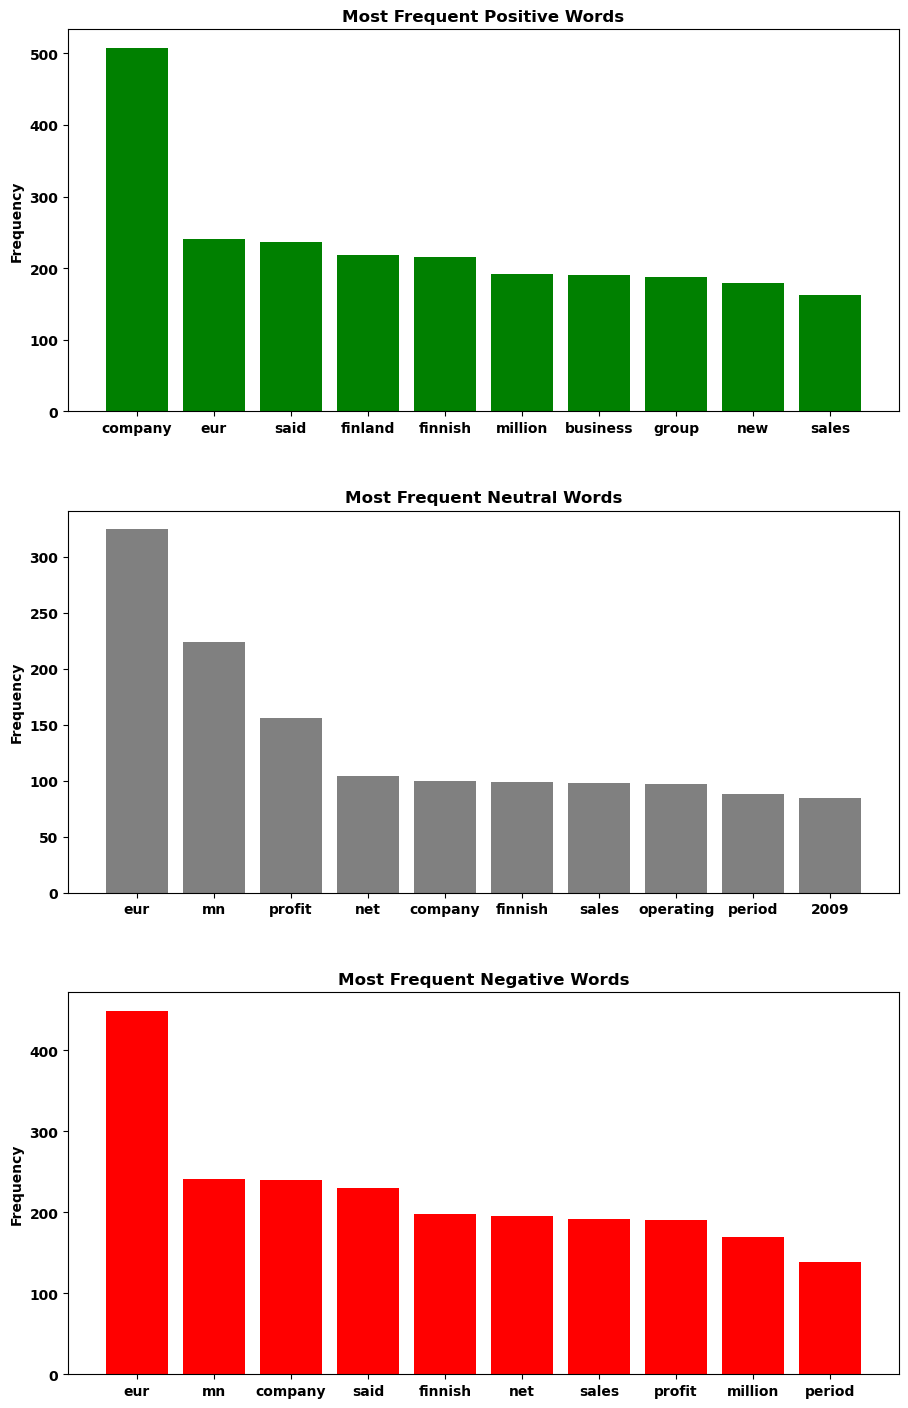

In [20]:
# Spliting the tupple we got earlier
positive_words, positive_counts = zip(*top_positive_words)
negative_words, negative_counts = zip(*top_negative_words)
neutral_words, neutral_counts = zip(*top_neutral_words)

# Charts----------------------------------------------------
fig, axs = plt.subplots(3,1,figsize=(10,15))

# Positive words plot
axs[0].bar(positive_words, positive_counts, color='green')
axs[0].set_title('Most Frequent Positive Words')
axs[0].set_ylabel('Frequency')

# Negative words plot
axs[1].bar(neutral_words, neutral_counts, color='grey')
axs[1].set_title('Most Frequent Neutral Words')
axs[1].set_ylabel('Frequency')

# Neutral words plot
axs[2].bar(negative_words, negative_counts, color='red')
axs[2].set_title('Most Frequent Negative Words')
axs[2].set_ylabel('Frequency')

# Space between charts
plt.tight_layout(pad=4.0)
plt.show()           
           
#Resources:
# https://realpython.com/python-zip-function/#using-zip-in-python
# https://matplotlib.org/stable/index.html

# E) Spliting data

In [21]:
# Splitting data into train 70%, validation 15%, test 15%

X_train_val, X_test, y_train_val, y_test = train_test_split(df50['sentence_preprocessed_1'], df50['label'], test_size=0.15, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.15, random_state=42)

# F) Feature extraction TF-IDF

In [22]:
# Feature extraction: Transforming data into TF-IDF features.
X_train = tfidf_vectorizer.fit_transform(X_train)
X_val = tfidf_vectorizer.transform(X_val)
X_test = tfidf_vectorizer.transform(X_test)

In [23]:
# Checking shape
print(X_train.shape)  
print(X_test.shape)   
print(X_val.shape)

(3501, 9185)
(727, 9185)
(618, 9185)


# G) SVM model and data input adaptation 

In [24]:
#Turning sparse matrix into dense
X_train = X_train.toarray()
X_val = X_val.toarray()
X_test = X_test.toarray()

#Turning into PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32)
y_val = torch.tensor(y_val.values, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32)

#Resources:
# https://pytorch.org/docs/stable/tensors.html

In [25]:
# Time Consumed (starts)
start_time = time.time()

# Initialize the Support Vector Machine classifier with default parameters
svm_model = SVC()

# Fit the model 
svm_model.fit(X_train, y_train)

# Predict the labels 
y_pred = svm_model.predict(X_test)

# Calculate the accuracy 
accuracy = accuracy_score(y_test, y_pred)

# Print the accuracy
print(f"Accuracy: {accuracy:.2f}")


# Total Time Consumed 
end_time = time.time()
execution_time = end_time - start_time
print(f"Total Execution Time: {execution_time} seconds")

Accuracy: 0.72
Total Execution Time: 115.18527054786682 seconds
